In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Loading Word2Vec and GLoVe embeddings trained on our corpus

In [2]:
# Load in word2vec embeddings

w2v_model = KeyedVectors.load_word2vec_format("data/w2v_embeddings.txt", binary=False)
w2v_word_to_embeddings = {word: w2v_model[word] for word in w2v_model.vocab}

In [3]:
# Load in GLoVe embeddings

glove_file = "data/glove.6B.200d.txt"
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
glove_model = KeyedVectors.load_word2vec_format(tmp_file)
# glove_model = KeyedVectors.load_word2vec_format("glove.6B.200d.txt", binary=False)
glove_word_to_embeddings = {word: glove_model[word] for word in glove_model.vocab}

In [5]:
# Load in the dataset with processed lyrics

dataset = pd.read_csv("data/Processed_Lyric_Dataset.csv")

In [6]:
# Drop unneeded columns and evaluate the lyrics list to be a python list instead of string

dataset = dataset.drop(columns=["Unnamed: 0", "LyricsList"], axis=1)
dataset["LyricsList"] = dataset.apply(lambda x: eval(x['LyricProcessed']), axis=1)
dataset = dataset.drop(columns=["Artist", "Lyric", "LyricProcessed"])
dataset.head(5)

,SName,Genre,LyricsList
0,Careless Whisper,pop,"[[feel, unsure], [take, hand, lead, dance, flo..."
1,Could You Be Loved / Citação Musical do Rap: S...,pop,"[[let, fool, ya], [even, try, school, ya, oh],..."
2,Cruisin' (Part. Saulo),pop,"[[baby, let, cruise, away], [confuse, way, cle..."
3,Easy,pop,"[[know, sound, funny], [cant, stand, pain], [g..."
4,For Your Babies (The Voice cover),pop,"[[get, look], [one, hop, lad], [face, beam], [..."


In [7]:
# Check count of different genres

dataset["Genre"].value_counts()

rock           29916
metal          19420
pop            12812
hip-hop        10333
indie           6020
electronic      5866
rap             4535
rnb             4271
soul            3739
punk            3440
country         3135
jazz            2969
folk            2724
alternative     1994
blues           1838
reggae          1697
Name: Genre, dtype: int64

In [8]:
# Create a label map for the genres
genres = dataset["Genre"].unique()
genre_map = {g: i for i, g in enumerate(genres)}

# Featurizing every song by adding vectors of every word in lyrics and dividing it by the length of the song

In [9]:
w2v_training_data = []
glove_training_data = []
training_labels = []

for _, row in dataset.iterrows():
    label = row["Genre"]
    lyrics = row["LyricsList"]
    w2v_feature_vector = np.zeros((200,))
    glove_feature_vector = np.zeros((200,))
    song_length = 0
    for line in lyrics:
        song_length += len(line)
        for word in line:
            if word in w2v_word_to_embeddings:
                w2v_feature_vector += w2v_word_to_embeddings[word]
            if word in glove_word_to_embeddings:
                glove_feature_vector += glove_word_to_embeddings[word]
    if song_length == 0:
        w2v_training_data.append(w2v_feature_vector)
        glove_training_data.append(glove_feature_vector)
    else:
        w2v_training_data.append(w2v_feature_vector/song_length)
        glove_training_data.append(glove_feature_vector/song_length)
    training_labels.append(genre_map[label])

In [10]:
# Split dataset into training and testing datasets for word2vec embeddings
word2vec_X_train, word2vec_X_test, word2vec_y_train, word2vec_y_test = train_test_split(w2v_training_data, training_labels, test_size=0.2, random_state=42)

In [11]:
# Split dataset into training and testing datasets for GLoVe embeddings
glove_X_train, glove_X_test, glove_y_train, glove_y_test = train_test_split(glove_training_data, training_labels, test_size=0.2, random_state=42)

# Baseline Gaussian Naive Bayes classifier

### Word2Vec Embeddings used for training

In [12]:
# Initialize a Gaussian NB
word2vec_gaussian_nb = GaussianNB()
# Fit it on word2vec training data
word2vec_gaussian_nb.fit(word2vec_X_train, word2vec_y_train)

GaussianNB()

In [13]:
# Predict outputs by model for test data
word2vec_gaussian_y_pred = word2vec_gaussian_nb.predict(word2vec_X_test)

# Calculate accuracy, precision, recall and F1 score
word2vec_gaussian_accuracy = accuracy_score(word2vec_y_test, word2vec_gaussian_y_pred)
w2v_precision, w2v_recall, w2v_f1, _ = precision_recall_fscore_support(word2vec_y_test, word2vec_gaussian_y_pred, average = 'weighted')

print("Performance metrics for Gaussian Naive Bayes Classifier with Word2Vec embeddings")
print("Accuracy:", word2vec_gaussian_accuracy)
print("Precision:", w2v_precision)
print("Recall:", w2v_recall)
print("F1 Score:", w2v_f1)

Performance metrics for Gaussian Naive Bayes Classifier with Word2Vec embeddings
Accuracy: 0.26440589312178536
Precision: 0.3116100783669175
Recall: 0.26440589312178536
F1 Score: 0.24427408416231794


### GLoVe Embeddings used for Training

In [14]:
# Initialize a Gaussian NB
glove_gaussian_nb = GaussianNB()
# Fit it on GLoVe training data
glove_gaussian_nb.fit(glove_X_train, glove_y_train)

GaussianNB()

In [15]:
# Predict outputs by model for test data
glove_y_pred = glove_gaussian_nb.predict(glove_X_test)

# Calculate accuracy, precision, recall and F1 score
glove_gaussian_accuracy = accuracy_score(glove_y_test, glove_y_pred)
glove_precision, glove_recall, glove_f1, _ = precision_recall_fscore_support(glove_y_test ,glove_y_pred, average = 'weighted')

print("Performance metrics for Gaussian Naive Bayes Classifier with GLoVe embeddings")
print("Accuracy:", glove_gaussian_accuracy)
print("Precision:", glove_precision)
print("Recall:", glove_recall)
print("F1 Score:", glove_f1)

Performance metrics for Gaussian Naive Bayes Classifier with GLoVe embeddings
Accuracy: 0.2369453404236771
Precision: 0.28311607599003313
Recall: 0.2369453404236771
F1 Score: 0.21222811303353573


# Logistic Regression Models as classifiers

In [16]:
def logistic_regression_accuracy(embeddings, penalty='no', C=1.0):
    """
    Helper method to implement Logistic Regression models using sklearn and different hyperparameters
    :param embeddings: choice between word2vec and GLoVe embeddings
    :param penalty: Type of regularization
    :param C: Strength of regularization
    :return: Accuracy, precision, recall and F1 score of the model
    """
    if embeddings == 'word2vec':
        word_embeddings = w2v_training_data
    elif embeddings == "glove":
        word_embeddings = glove_training_data

    X_train, X_test, y_train, y_test = train_test_split(word_embeddings, training_labels, test_size=0.2, random_state=42)

    if penalty == 'no':
        logistic_classifier = LogisticRegression(multi_class='multinomial', max_iter=1000)
    elif penalty == 'l1':
        logistic_classifier = LogisticRegression(multi_class='multinomial', max_iter=1000, penalty='l1', C=C, solver='saga')
    elif penalty == 'l2':
        logistic_classifier = LogisticRegression(multi_class='multinomial', max_iter=1000, penalty='l2', C=C)
    else:
        raise ValueError('Invalid penalty type')

    logistic_classifier.fit(X_train, y_train)

    y_pred = logistic_classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print("Performance metrics for Logistic Regression Classifier with", embeddings, "embeddings and", penalty, "penalty")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("")
    return accuracy, precision, recall, f1

In [17]:
print("Word2Vec Embeddings")
word2vec_accuracy = logistic_regression_accuracy("word2vec")
word2vec_l1_accuracy = logistic_regression_accuracy("word2vec", penalty='l1', C=1.0)
word2vec_l2_accuracy = logistic_regression_accuracy("word2vec", penalty='l2', C=1.0)

Word2Vec Embeddings
Performance metrics for Logistic Regression Classifier with word2vec embeddings and no penalty
Accuracy: 0.4301281492459245
Precision: 0.4029629873890718
Recall: 0.4301281492459245
F1 Score: 0.36919746261427183

Performance metrics for Logistic Regression Classifier with word2vec embeddings and l1 penalty
Accuracy: 0.4307383837503269
Precision: 0.4027637004738841
Recall: 0.4307383837503269
F1 Score: 0.3710428223525167

Performance metrics for Logistic Regression Classifier with word2vec embeddings and l2 penalty
Accuracy: 0.4301281492459245
Precision: 0.4029629873890718
Recall: 0.4301281492459245
F1 Score: 0.36919746261427183



In [18]:
print("GLoVe Embeddings")
glove_accuracy = logistic_regression_accuracy("glove")
glove_l1_accuracy = logistic_regression_accuracy("glove", penalty='l1', C=1.0)
glove_l2_accuracy = logistic_regression_accuracy("glove", penalty='l2', C=1.0)

GLoVe Embeddings
Performance metrics for Logistic Regression Classifier with glove embeddings and no penalty
Accuracy: 0.40929299973847094
Precision: 0.37940986320477826
Recall: 0.40929299973847094
F1 Score: 0.34349756379757873

Performance metrics for Logistic Regression Classifier with glove embeddings and l1 penalty
Accuracy: 0.41038270421061807
Precision: 0.38032277767338246
Recall: 0.41038270421061807
F1 Score: 0.3454281914558479

Performance metrics for Logistic Regression Classifier with glove embeddings and l2 penalty
Accuracy: 0.40929299973847094
Precision: 0.37940986320477826
Recall: 0.40929299973847094
F1 Score: 0.34349756379757873



In [19]:
class LogReg(nn.Module):
    """
    Class inheriting PyTorch module to create a 1 layer linear neural network for Logistic Regression model.
    """
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(200, 16)

    def forward(self, x):
        x = self.layer(x)
        return x

In [20]:
def train(model, embeddings, epochs, penalty = 'no', C=1.0, lr = 0.01, verbose=False):
    """
    Trains a PyTorch implementation of Logistic Regression model
    :param model: The logistic regression model
    :param embeddings: GLoVe or word2vec embeddings to be used for training
    :param epochs: Number of epochs to train model for
    :param penalty: Regularization being used
    :param C: Strength of regularization
    :param lr: Learning rate for gradient descent
    :param verbose: Print progress of training
    :return: Training losses over epochs, testing losses over epochs, best accuracy and best F1 score
    """
    loss_func = nn.CrossEntropyLoss()
    if embeddings == 'word2vec':
        word_embeddings = w2v_training_data
    elif embeddings == "glove":
        word_embeddings = glove_training_data

    X_train, X_test, y_train, y_test = train_test_split(word_embeddings, training_labels, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    if penalty == 'no':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif penalty == 'l1':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=C, momentum=0.9)
    elif penalty == 'l2':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=C)
    else:
        raise ValueError('Invalid penalty type')

    train_losses = []
    val_losses = []
    best_accuracy = 0.0
    best_f1_score = 0.0
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_func(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            loss = loss_func(outputs, y_test)
            val_losses.append(loss.item())

        # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            accuracy = (predicted == y_test).sum().item() / len(y_test)
            if accuracy > best_accuracy:
                best_accuracy = accuracy

            precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predicted, average='weighted', zero_division = 1.0)
            if f1_score > best_f1_score:
                best_f1_score = f1_score

        if verbose:
            if int(epochs//3) == 33:
                print("33% training done.")
            elif int(epochs//6) == 66:
                print("66% training done.")

    return train_losses, val_losses, best_accuracy, best_f1_score

In [21]:
def visualize_validation_training_loss(training_loss, validation_loss):
    """
    Plots the training and validation losses vs epochs
    :param training_loss: List of training losses
    :param validation_loss: List of validation losses
    :return: None
    """
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

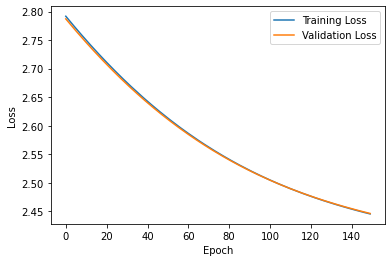

Best accuracy: 0.2577804899311307
BEst F1 score: 0.11584690820964878


In [22]:
w2v_logistic = LogReg()
w2v_training_loss, w2v_testing_loss, best_accuracy, best_f1 = train(w2v_logistic, 'word2vec', 150)
visualize_validation_training_loss(w2v_training_loss, w2v_testing_loss)
print("Best accuracy:", best_accuracy)
print("BEst F1 score:", best_f1)

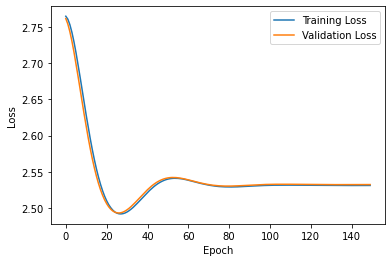

Best accuracy: 0.25782407811001656
BEst F1 score: 0.10971816423513804


In [23]:
w2v_logistic = LogReg()
w2v_training_loss, w2v_testing_loss, best_accuracy, best_f1 = train(w2v_logistic, 'word2vec', 150, penalty='l1')
visualize_validation_training_loss(w2v_training_loss, w2v_testing_loss)
print("Best accuracy:", best_accuracy)
print("BEst F1 score:", best_f1)

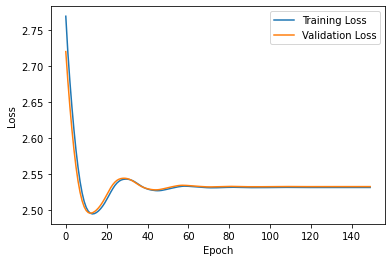

Best accuracy: 0.2579984308255601
BEst F1 score: 0.1086042751126228


In [24]:
w2v_logistic = LogReg()
w2v_training_loss, w2v_testing_loss, best_accuracy, best_f1 = train(w2v_logistic, 'word2vec', 150, penalty='l2')
visualize_validation_training_loss(w2v_training_loss, w2v_testing_loss)
print("Best accuracy:", best_accuracy)
print("BEst F1 score:", best_f1)

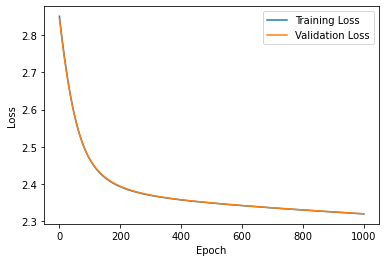

Best accuracy: 0.2772644058931218
BEst F1 score: 0.14413734847191736


In [25]:
glove_logistic = LogReg()
glove_training_loss, glove_testing_loss, best_accuracy, best_f1 = train(glove_logistic, 'glove', 1000)
visualize_validation_training_loss(glove_training_loss, glove_testing_loss)
print("Best accuracy:", best_accuracy)
print("BEst F1 score:", best_f1)

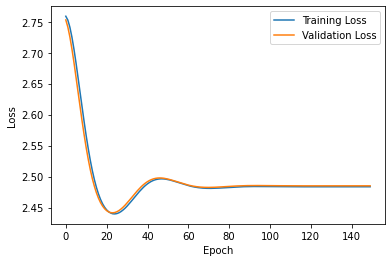

Best accuracy: 0.25782407811001656
BEst F1 score: 0.10713009936674013


In [26]:
glove_logistic = LogReg()
glove_training_loss, glove_testing_loss, best_accuracy, best_f1 = train(glove_logistic, 'glove', 150, penalty='l1')
visualize_validation_training_loss(glove_training_loss, glove_testing_loss)
print("Best accuracy:", best_accuracy)
print("BEst F1 score:", best_f1)

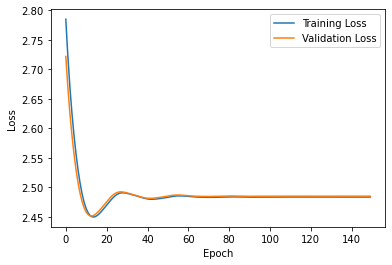

Best accuracy: 0.2778746403975242
BEst F1 score: 0.16254116624188553


In [27]:
glove_logistic = LogReg()
glove_training_loss, glove_testing_loss, best_accuracy, best_f1 = train(glove_logistic, 'glove', 150, penalty='l2')
visualize_validation_training_loss(glove_training_loss, glove_testing_loss)
print("Best accuracy:", best_accuracy)
print("BEst F1 score:", best_f1)